In [2]:
import numpy as np
import pyedflib
import matplotlib.pyplot as plt
import scipy.signal as sig
import statsmodels.api as sm
import pandas as pd
import os

from sklearn.model_selection import train_test_split
from mne.decoding import CSP

In [3]:
def plot_signal_with_annotations_and_state_changes(signals,signal_labels, start_event_times, durations, descriptions, fs, 
                                                   signal_idx="C1", start_time=0, end_time=None,S=False, S_signal_select = 0):
    
    
    if not S:
        signal_idx_index = signal_labels.index(signal_idx)

        # Select the signal to plot
        signal = signals[signal_idx_index]
    else:
        signal = signals[S_signal_select]
        signal_idx  = "S"  + str(S_signal_select + 1)

    # Determine the sample range for the specified time window
    if end_time is None:
        end_time = len(signal) / fs  # Default to the entire signal duration
    start_sample = int(start_time * fs)
    end_sample = int(end_time * fs)

    # Extract the portion of the signal to display
    signal_segment = signal[start_sample:end_sample]
    time_segment = np.linspace(start_time, end_time, len(signal_segment))

    # Filter annotations to match the time window
    filtered_events = [
        (start, dur, desc) for start, dur, desc in zip(start_event_times, durations, descriptions)
        if start >= start_time and start < end_time
    ]

    # Plot the signal
    plt.figure(figsize=(15, 6))
    plt.plot(time_segment, signal_segment, label=f"Signal {signal_idx}", color="blue", linewidth=1)
    plt.title(f"Signal {signal_idx} with Annotations (Time {start_time}s to {end_time}s)")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)

    # Plot colored annotation bars and vertical lines for state changes
    color_map = {"T0": "green", "T1": "red", "T2": "orange"}  # Map descriptions to colors
    y_bar_pos = max(signal_segment) + 10  # Position for annotation bars
    prev_description = None  # Keep track of the previous state
    for start, duration, description in filtered_events:
        # Plot annotation bar
        color = color_map.get(description, "black")  # Default to black if description not in color_map
        plt.hlines(y_bar_pos, start, start + duration, colors=color, linewidth=8, label=description if start == filtered_events[0][0] else "")
        plt.text(
            start + duration / 2, y_bar_pos + 5, description, color=color, fontsize=8, ha="center", va="bottom"
        )

        # Plot vertical line for state change
        if description != prev_description:  # State change detected
            plt.axvline(x=start, color="black", linestyle="--", linewidth=1, alpha=0.7, label="State Change" if prev_description is None else "")
        prev_description = description

    # Avoid duplicate labels in legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    # Adjust axis limits to accommodate annotations
    
    plt.ylim([min(signal_segment) - 10, y_bar_pos + 10])

    # Show the plot
    plt.show()

In [4]:
#filtering with band-pass fir filter
def filter_with_bandpass(S,fs,low_cutoff = 8,high_cutoff = 13,order = 501, plot_filter=False):
    S_filtered = np.copy(S)

    b = sig.firwin(order, [low_cutoff, high_cutoff], fs=fs, pass_zero = False)
    
    for i in range(len(S_filtered)):
        
        S_filtered[i] = sig.lfilter(b,[1],S_filtered[i])


    if plot_filter:
        w,h = sig.freqz(b)
        plt.plot(w * fs / (2 * np.pi), abs(h), 'b')
        plt.title('Band-Pass Filter Frequency Response (8.0 Hz to 13.0 Hz)')
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('Gain')
        plt.grid(True)
        plt.show()
    
    return S_filtered

In [5]:
#READING THE SIGNALS
def read_edf(rec_name):
    #read edf file 
    edf_file = pyedflib.EdfReader(rec_name)

    #num of signals
    n_signals = edf_file.signals_in_file

    #labels of which signals it is (on the head)
    signal_labels = edf_file.getSignalLabels()
    signal_labels = [label.replace(".", "") for label in signal_labels]

    #sampling freq
    sample_frequency = edf_file.getSampleFrequencies()
    sample_frequency = sample_frequency[0]

    #get annotations on the signal (T0, T1,T2)
    annotations = edf_file.readAnnotations()
    start_event_times = annotations[0]
    durations = annotations[1]

    #T0 is the base state, T1 is the imagining of clinching left fist, T2 is the imagining of clinching of right fist
    descriptions = annotations[2]
    
    #all 64 signals
    signals = np.zeros((n_signals, len(edf_file.readSignal(0))))
    for i in range(n_signals):
        signal = edf_file.readSignal(i)
        signals[i] = signal
    signals = filter_with_bandpass(signals, sample_frequency)
    edf_file.close()
    return signals,signal_labels,start_event_times, durations, descriptions, sample_frequency

In [6]:
def separate_signals_by_class(matrix, start_event_times, durations, descriptions, fs):
    #get samples instead of seconds
    start_event_samples = [int(start*fs) for start in start_event_times]
    duration_samples = [int(duration * fs) for duration in durations]

    signals_T1 = []
    signals_T2 = []

    #through all states
    for i in range(len(start_event_samples)):
        #matrix of the current state
        tmp_mtx = np.zeros((64, duration_samples[i]))
        tmp_mtx = matrix[:,start_event_samples[i]:start_event_samples[i] + duration_samples[i]]

        #cases for each state, calculate covariace and add to the avg covaricance matrix
        if descriptions[i] == "T1":
            signals_T1.append(tmp_mtx)

        elif descriptions[i] == "T2":
            signals_T2.append(tmp_mtx)
    
    return signals_T1, signals_T2

In [10]:
def apply_csp_to_one(path):
    signals, signal_labels, start_event_times, durations, descriptions, fs = read_edf(path)
    signals_T1, signals_T2 = separate_signals_by_class(signals, start_event_times, durations, descriptions, fs)
    labels_T1 = ["T1"] * len(signals_T1)
    labels_T2 = ["T2"] * len(signals_T2)
    data = signals_T1 + signals_T2
    labels = labels_T1 + labels_T2
    data = np.array(data)
    labels = np.array(labels)
    print(data)
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.8, random_state=42)
    csp = CSP(n_components=6, reg=None, log=True)

    #csp.fit(data,labels)
    csp.fit(X_train, y_train)

    #X_train_csp = csp.fit_transform(X_train, y_train)

    #X_test_csp = csp.transform(X_test)
    
    return csp.filters_

In [11]:
#RO4 files are the files where imagining clinching left and right fist
signals, signal_labels, start_event_times, durations, descriptions, fs = read_edf("files/S001/S001R04.edf")
filter_matrix = apply_csp_to_one("files/S001/S001R04.edf")
S = filter_matrix @ signals

[[[-2.77747478e+00  2.54133749e+00  7.47538458e+00 ... -2.28597254e+01
   -1.97968016e+01 -1.33894444e+01]
  [-5.89524056e+00 -5.34504222e-01  5.16877989e+00 ... -2.55306819e+01
   -2.40142686e+01 -1.85906956e+01]
  [-4.31887526e+00 -2.74798898e-01  4.02775241e+00 ... -2.92086321e+01
   -2.59723390e+01 -1.87520976e+01]
  ...
  [-1.44281319e+01 -8.60557329e+00 -1.78792440e-01 ... -4.04087064e+01
   -4.13010123e+01 -3.33998306e+01]
  [-1.06134289e+01 -6.49818287e+00 -8.83667920e-02 ... -3.63817346e+01
   -3.02271857e+01 -1.77974315e+01]
  [-8.93211307e+00 -4.18413433e+00  2.38921438e+00 ... -3.98278312e+01
   -3.86749475e+01 -2.90346304e+01]]

 [[ 4.99375448e+00  6.37487794e+00  5.92911328e+00 ... -3.32214025e+00
    1.17381956e+00  4.95363548e+00]
  [ 3.69009435e+00  2.56494145e+00  2.73831354e-01 ... -3.26169100e+00
    2.14402667e+00  6.36328634e+00]
  [ 5.41966163e+00  2.98499397e+00 -6.60226542e-01 ... -1.96709129e+00
    1.64764574e+00  4.29254484e+00]
  ...
  [ 3.82376831e+00  2.1

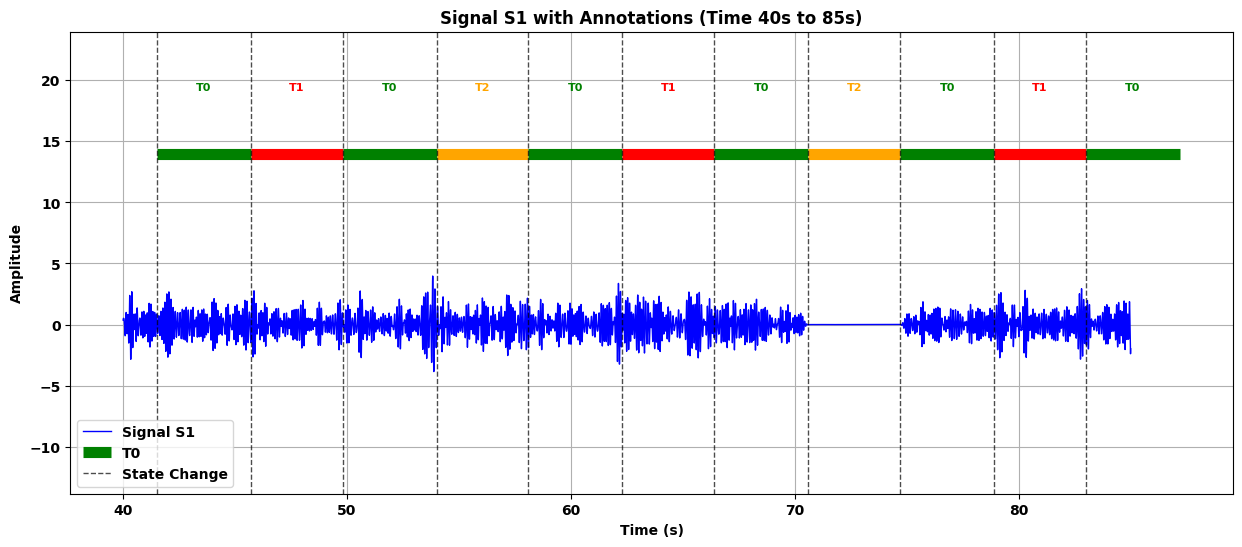

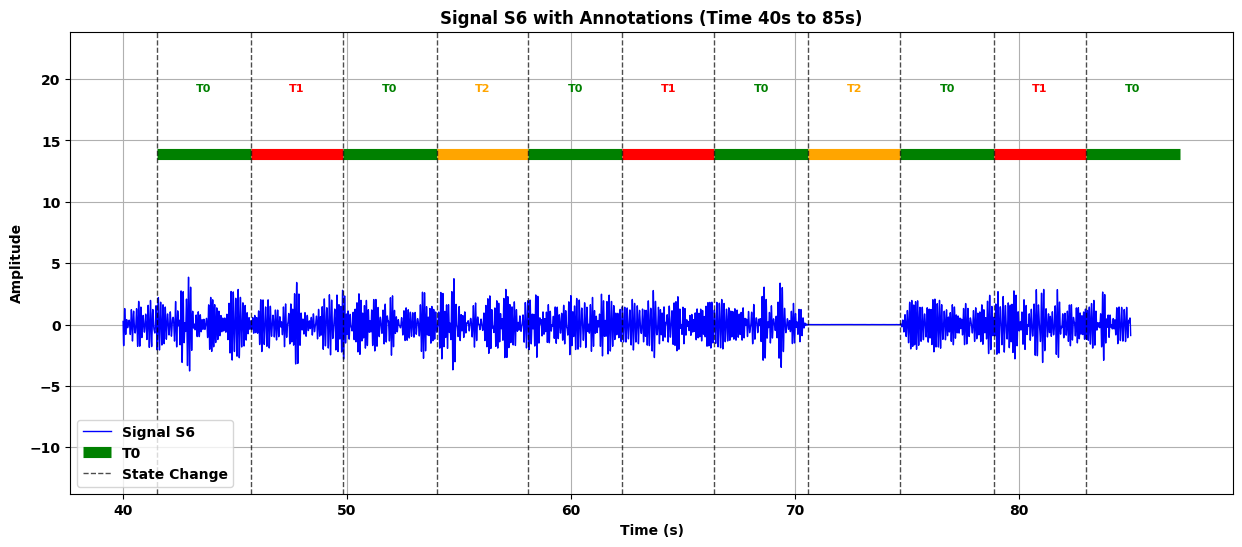

In [145]:
plot_signal_with_annotations_and_state_changes(S, signal_labels, start_event_times, durations, descriptions, fs, S = True, S_signal_select=0, start_time=40, end_time=85)
plot_signal_with_annotations_and_state_changes(S, signal_labels, start_event_times, durations, descriptions, fs, S = True, S_signal_select=5, start_time=40, end_time=85)

In [8]:
signals, signal_labels, start_event_times, durations, descriptions, fs = read_edf("files/S001/S001R04.edf")
signals_T1, signals_T2 = separate_signals_by_class(signals, start_event_times, durations, descriptions, fs)
labels_T1 = ["T1"] * len(signals_T1)
labels_T2 = ["T2"] * len(signals_T2)
data = signals_T1 + signals_T2
labels = labels_T1 + labels_T2
data = np.array(data)
labels = np.array(labels)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
csp = CSP(n_components=6, reg=None, log=True)

X_train_csp = csp.fit_transform(X_train, y_train)
 
X_test_csp = csp.transform(X_test)

X_test_csp

Computing rank from data with rank=None
    Using tolerance 97 (2.2e-16 eps * 64 dim * 6.8e+15  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=T1 covariance using EMPIRICAL
Done.
Estimating class=T2 covariance using EMPIRICAL
Done.


array([[-1.5178429 , -1.09608914, -1.23150735, -0.49505595, -0.89654472,
        -0.62781652],
       [-0.84809095, -0.26770296, -0.35359367, -0.22919301, -0.64240676,
        -0.46106821],
       [ 0.25270818, -0.44032254, -0.64555012, -0.81726399, -0.76625226,
        -0.68046745]])